In [0]:
from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip

builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.sql("USE CATALOG hive_metastore")
spark.sql("USE default")


DataFrame[]

In [0]:
import datetime as dt
from pyspark.sql import functions as F, types as T

trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

trips_rows = [
    (1001,"R001","D010","Bengaluru", 12.4, 320.0, 20.0, dt.datetime(2025,8,8,8,5)),
    (1002,"R002","D011","Hyderabad", 6.2, 150.0, 10.0, dt.datetime(2025,8,8,8,15)),
    (1003,"R003","D012","Pune", 3.5, 90.0, 0.0, dt.datetime(2025,8,8,8,20)),
    (1004,"R001","D010","Bengaluru", 18.9, 480.0, 25.0, dt.datetime(2025,8,8,8,45)),
    (1005,"R004","D013","Chennai", 10.0, 260.0, 15.0, dt.datetime(2025,8,8,9,5)),
    (1006,"R005","D012","Pune", 2.2, 70.0, 0.0, dt.datetime(2025,8,8,9,10)),
]

drivers_rows = [
    ("D010","Anil",   4.8,"WagonR"),
    ("D011","Sana",   4.6,"i20"),
    ("D012","Rakesh", 4.4,"Swift"),
    ("D013","Meera",  4.9,"Ciaz")
]

trips_df   = spark.createDataFrame(trips_rows,   trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, driver_schema)

BASE         = "dbfs:/tmp/delta/ride_hailing"
TRIPS_PATH   = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print("Seeded:")
print(" Trips   ->", TRIPS_PATH)
print(" Drivers ->", DRIVERS_PATH)


Seeded:
 Trips   -> dbfs:/tmp/delta/ride_hailing/trips
 Drivers -> dbfs:/tmp/delta/ride_hailing/drivers


In [0]:
# Managed
spark.sql(f"""
CREATE OR REPLACE TABLE trips_managed
USING DELTA
AS SELECT * FROM delta.`{TRIPS_PATH}`
""")

# Unmanaged
spark.sql(f"""
CREATE TABLE IF NOT EXISTS drivers_ext
USING DELTA
LOCATION '{DRIVERS_PATH}'
""")

print("DETAIL trips_managed:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)
print("DETAIL drivers_ext:")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)


DETAIL trips_managed:
+------+------------------------------------+------------------------------------+-----------+---------------------------------------+-----------------------+-------------------+----------------+-----------------+--------+-----------+-------------------------------------+----------------+----------------+-----------------------------------------+---------------------------------------------------------------+-------------+
|format|id                                  |name                                |description|location                               |createdAt              |lastModified       |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties                           |minReaderVersion|minWriterVersion|tableFeatures                            |statistics                                                     |clusterByAuto|
+------+------------------------------------+------------------------------------+-----------+------------------------------

Managed Table:databricks controls data storage and metadata
unmanaged Table:databricks controls only metadata

Managed Table:dropping the table will removes both the metadata and data files
Unmanaged Table:dropping the table will keeps the data files we can read them directly

2.Read & Explore.

In [0]:
# Read both tables
trips_df = spark.table("trips_managed")
drivers_df = spark.table("drivers_ext")

# Print schemas
trips_df.printSchema()
drivers_df.printSchema()

root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)



In [0]:
# Show 10 rows
trips_df.show(10, truncate=False)
drivers_df.show(10, truncate=False)


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|
|1006   |R005    |D012     |Pune     |2.2        |70.0 |0.0 |2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|D010     |Anil       |4.8   |WagonR |
|D011     |Sana       |

In [0]:
# Add derived column total_amount = fare + tip
trips_df = trips_df.withColumn("total_amount", F.col("fare") + F.col("tip"))

# Show top 5 trips by total_amount
trips_df.orderBy(F.desc("total_amount")).show(5, truncate=False)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|505.0       |
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|340.0       |
|1005   |R004    |D013     |Chennai  |10.0       |260.0|15.0|2025-08-08 09:05:00|275.0       |
|1002   |R002    |D011     |Hyderabad|6.2        |150.0|10.0|2025-08-08 08:15:00|160.0       |
|1003   |R003    |D012     |Pune     |3.5        |90.0 |0.0 |2025-08-08 08:20:00|90.0        |
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
only showing top 5 rows


3) Update (Business Rule)
Increase tip by 5 for trips in Bengaluru where distance_km > 15 .

In [0]:
# Show BEFORE
spark.sql("""
SELECT trip_id, city, distance_km, fare, tip
FROM trips_managed
WHERE city = 'Bengaluru' AND distance_km > 15
""").show()

+-------+---------+-----------+-----+----+
|trip_id|     city|distance_km| fare| tip|
+-------+---------+-----------+-----+----+
|   1004|Bengaluru|       18.9|480.0|25.0|
+-------+---------+-----------+-----+----+



In [0]:
# UPDATE
spark.sql("""
UPDATE trips_managed
SET tip = tip + 5
WHERE city = 'Bengaluru' AND distance_km > 15
""")

DataFrame[num_affected_rows: bigint]

In [0]:
# Show AFTER
spark.sql("""
SELECT trip_id, city, distance_km, fare, tip
FROM trips_managed
WHERE city = 'Bengaluru' AND distance_km > 15
""").show()

+-------+---------+-----------+-----+----+
|trip_id|     city|distance_km| fare| tip|
+-------+---------+-----------+-----+----+
|   1004|Bengaluru|       18.9|480.0|30.0|
+-------+---------+-----------+-----+----+



4) Delete (Data Quality)

In [0]:
# Delete Delete trips where fare <= 0 or distance_km <= 0 (simulate bad ingest).
spark.sql("""
DELETE FROM trips_managed
WHERE fare <= 0 OR distance_km <= 0
""")

# Show remaining row count
spark.sql("""
SELECT COUNT(*) AS remaining_rows
FROM trips_managed
""").show()


+--------------+
|remaining_rows|
+--------------+
|             6|
+--------------+



5) Merge (Upsert New Batch)

In [0]:
from pyspark.sql import Row
merge_rows = [
    Row(trip_id=1004, rider_id="R001", driver_id="D010", city="Bengaluru",
        distance_km=18.9, fare=480.0, tip=40.0, ts="2025-08-08 08:45:00"),  # updated tip
    Row(trip_id=1007, rider_id="R006", driver_id="D013", city="Hyderabad",
        distance_km=8.0, fare=200.0, tip=15.0, ts="2025-08-08 10:00:00")    # new trip
]

merge_df = spark.createDataFrame(merge_rows)

# Save to a temp Delta path
MERGE_PATH = "/tmp/delta/ride_hailing/merge_batch"
merge_df.write.format("delta").mode("overwrite").save(MERGE_PATH)

# Merge into trips_managed
spark.sql(f"""
MERGE INTO trips_managed AS t
USING delta.`{MERGE_PATH}` AS s
ON t.trip_id = s.trip_id
WHEN MATCHED THEN UPDATE SET *
WHEN NOT MATCHED THEN INSERT *
""")

# Confirm the update & insert
spark.sql("""
SELECT * FROM trips_managed
WHERE trip_id IN (1004, 1007)
""").show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|40.0|2025-08-08 08:45:00|
|   1007|    R006|     D013|Hyderabad|        8.0|200.0|15.0|2025-08-08 10:00:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



6) Gold View (Join & KPIs)

In [0]:
# Create gold view with join
spark.sql("""
CREATE OR REPLACE TEMP VIEW gold_trips AS
SELECT t.trip_id, t.city, d.driver_name, d.rating,
       t.distance_km, (t.fare + t.tip) AS total_amount, t.ts
FROM trips_managed t
JOIN drivers_ext d
  ON t.driver_id = d.driver_id
""")


DataFrame[]

In [0]:
# City-wise total revenue & avg driver rating
spark.sql("""
SELECT city,
       ROUND(SUM(total_amount), 2) AS total_revenue,
       ROUND(AVG(rating), 2) AS avg_driver_rating
FROM gold_trips
GROUP BY city
""").show()

+---------+-------------+-----------------+
|     city|total_revenue|avg_driver_rating|
+---------+-------------+-----------------+
|  Chennai|        275.0|              4.9|
|     Pune|        160.0|              4.4|
|Bengaluru|        860.0|              4.8|
|Hyderabad|        375.0|             4.75|
+---------+-------------+-----------------+



In [0]:
# Driver-wise total trips & top 3 drivers by revenue
spark.sql("""
SELECT driver_name,
       COUNT(*) AS total_trips,
       ROUND(SUM(total_amount), 2) AS total_revenue
FROM gold_trips
GROUP BY driver_name
ORDER BY total_revenue DESC
LIMIT 3
""").show()

+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        860.0|
|      Meera|          2|        490.0|
|     Rakesh|          2|        160.0|
+-----------+-----------+-------------+



7) Time Travel & History

In [0]:
# Show table history
spark.sql("DESCRIBE HISTORY trips_managed").show(truncate=False)

# Read as of version 0
df_v0 = spark.read.format("delta").option("versionAsOf", 0).table("trips_managed")
print("Version 0 count:", df_v0.count())

# Compare with latest
df_latest = spark.table("trips_managed")
print("Latest count:", df_latest.count())

df_v0.show()
df_latest.show()


+-------+-------------------+---------------+----------------------------------+---------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+------------------+--------------------+-----------+-----------------+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

8) Partitioned Rewrite (Performance)

In [0]:
# New path for partitioned table
PARTITIONED_PATH = "/tmp/delta/ride_hailing/trips_partitioned"

# Rewrite with partition by city
spark.table("trips_managed") \
     .write.format("delta") \
     .mode("overwrite") \
     .partitionBy("city") \
     .save(PARTITIONED_PATH)

# Simple filter to observe read behavior
spark.read.format("delta").load(PARTITIONED_PATH) \
     .filter("city = 'Bengaluru'") \
     .show()


+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|40.0|2025-08-08 08:45:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



9) Incremental Load Simulation

In [0]:
from datetime import datetime

inc_batch = [
    (1008, "R007", "D013", "Mumbai", 7.0, 180.0, 10.0, datetime.strptime("2025-08-14 11:00:00", "%Y-%m-%d %H:%M:%S")),
    (1009, "R008", "D011", "Mumbai", 5.0, 120.0, 5.0, datetime.strptime("2025-08-14 11:15:00", "%Y-%m-%d %H:%M:%S"))
]

inc_df = spark.createDataFrame(inc_batch, schema=trip_schema)

# Append to Delta table
inc_df.write.format("delta").mode("append").save(TRIPS_PATH)


In [0]:
# Re-run city revenue
spark.read.format("delta").load(TRIPS_PATH).withColumn("total_amount", F.col("fare")+F.col("tip")) \
    .groupBy("city").sum("total_amount").show()

+---------+-----------------+
|     city|sum(total_amount)|
+---------+-----------------+
|  Chennai|            275.0|
|     Pune|            160.0|
|Bengaluru|            845.0|
|Hyderabad|            160.0|
|   Mumbai|            315.0|
+---------+-----------------+



10) Simple Streaming

In [0]:
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)

query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime='5 seconds').start()



In [0]:
query.stop()

11) Visualization (Pandas + Matplotlib)

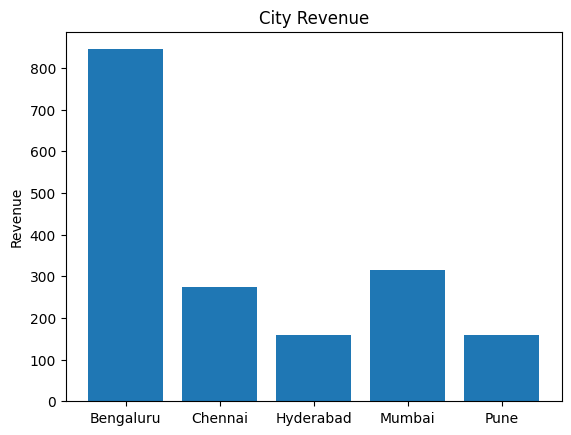

In [0]:
from pyspark.sql import functions as F

# Read Delta tables
trips = spark.read.format("delta").load(TRIPS_PATH)
drivers = spark.read.format("delta").load(DRIVERS_PATH)

# Create gold DataFrame
gold = trips.alias("t").join(drivers.alias("d"), "driver_id") \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .select("trip_id", "city", "driver_name", "rating", "distance_km", "total_amount", "ts")

# Convert to Pandas for plotting
import matplotlib.pyplot as plt

city_rev = gold.toPandas().groupby("city")["total_amount"].sum().reset_index()

plt.bar(city_rev['city'], city_rev['total_amount'])
plt.title("City Revenue")
plt.ylabel("Revenue")
plt.show()


12) Managed vs Unmanaged Cleanup

In [0]:
spark.sql("DROP TABLE trips_managed")
spark.sql("DROP TABLE drivers_ext")


DataFrame[]

13) Constraint/Quality Check

In [0]:
%sql
-- Create a managed Delta table for quality check
CREATE TABLE trips_managed_qc
USING DELTA
LOCATION '/tmp/delta/ride_hailing/trips_qc'
AS
SELECT * FROM delta.`/tmp/delta/ride_hailing/trips`;

-- Add a CHECK constraint 
ALTER TABLE trips_managed_qc
ADD CONSTRAINT tip_nonnegative CHECK (tip >= 0);


In [0]:
#bad data entry
%sql
-- This insert will fail due to the CHECK constraint
INSERT INTO trips_managed_qc VALUES
(1010, 'R009', 'D014', 'Bengaluru', 10.0, 200.0, -5.0, TIMESTAMP '2025-08-14 12:00:00');


---------------------------------------------------------------------------
SparkConnectGrpcException                 Traceback (most recent call last)
File <command-6566768326298991>, line 1
----> 1 get_ipython().run_cell_magic('sql', '', "-- This insert will fail due to the CHECK constraint\nINSERT INTO trips_managed_qc VALUES\n(1010, 'R009', 'D014', 'Bengaluru', 10.0, 200.0, -5.0, TIMESTAMP '2025-08-14 12:00:00');\n")

File /databricks/python/lib/python3.12/site-packages/IPython/core/interactiveshell.py:2541, in InteractiveShell.run_cell_magic(self, magic_name, line, cell)
   2539 with self.builtin_trap:
   2540     args = (magic_arg_s, cell)
-> 2541     result = fn(*args, **kwargs)
   2543 # The code below prevents the output from being displayed
   2544 # when using magics with decorator @output_can_be_silenced
   2545 # when the last Python token in the expression is a ';'.
   2546 if getattr(fn, magic.MAGIC_OUTPUT_CAN_BE_SILENCED, False):

File /databricks/python_shell/lib/dbrun

In [0]:
%sql
INSERT INTO trips_managed_qc VALUES
(1011, 'R010', 'D015', 'Mumbai', 8.0, 180.0, 10.0, TIMESTAMP '2025-08-14 12:30:00');


num_affected_rows,num_inserted_rows
1,1


14) Convert Parquet → Delta

In [0]:
# Save a small subset of trips as Parquet
trips_df = spark.read.format("delta").load("/tmp/delta/ride_hailing/trips")
parquet_path = "/tmp/delta/ride_hailing/trips_parquet"
trips_df.limit(3).write.mode("overwrite").format("delta").save(parquet_path)

# Convert Parquet to Delta
spark.sql(f"CONVERT TO DELTA parquet.`{parquet_path}`")

# Load as Delta
delta_table = DeltaTable.forPath(spark, parquet_path)

# MERGE example (upsert)
from pyspark.sql import functions as F
from datetime import datetime

new_batch = [
    (1012, "R011", "D011", "Hyderabad", 6.5, 150.0, 10.0, datetime.strptime("2025-08-14 12:45:00", "%Y-%m-%d %H:%M:%S"))
]
new_df = spark.createDataFrame(new_batch, schema=trip_schema)

delta_table.alias("t").merge(
    new_df.alias("n"),
    "t.trip_id = n.trip_id"
).whenNotMatchedInsertAll().execute()

# Time travel example: read version 0
version0_df = spark.read.format("delta").option("versionAsOf", 0).load(parquet_path)
display(version0_df)


trip_id,rider_id,driver_id,city,distance_km,fare,tip,ts
1001,R001,D010,Bengaluru,12.4,320.0,20.0,2025-08-08T08:05:00Z
1002,R002,D011,Hyderabad,6.2,150.0,10.0,2025-08-08T08:15:00Z
1003,R003,D012,Pune,3.5,90.0,0.0,2025-08-08T08:20:00Z


15) Bonus KPI Dashboard

In [0]:
from pyspark.sql import functions as F

# Load trips and drivers
trips = spark.read.format("delta").load("/tmp/delta/ride_hailing/trips")
drivers = spark.read.format("delta").load("/tmp/delta/ride_hailing/drivers")

# Gold view
gold = trips.alias("t").join(drivers.alias("d"), "driver_id") \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .select("trip_id", "city", "driver_name", "total_amount", "ts")

gold.createOrReplaceTempView("gold_view")

# Total revenue
display(spark.sql("SELECT SUM(total_amount) AS total_revenue FROM gold_view"))

total_revenue
1755.0


In [0]:
# Trips per city 
city_rev_df = spark.sql("""
SELECT city, SUM(total_amount) AS revenue
FROM gold_view
GROUP BY city
ORDER BY revenue DESC
""")
display(city_rev_df) 

city,revenue
Bengaluru,845.0
Mumbai,315.0
Chennai,275.0
Pune,160.0
Hyderabad,160.0


In [0]:
# Top drivers by revenue
driver_rev_df = spark.sql("""
SELECT driver_name, SUM(total_amount) AS revenue
FROM gold_view
GROUP BY driver_name
ORDER BY revenue DESC
""")
display(driver_rev_df)

driver_name,revenue
Anil,845.0
Meera,465.0
Sana,285.0
Rakesh,160.0


In [0]:
# Revenue by hour
hourly_rev_df = gold.withColumn("hour", F.hour("ts")) \
                    .groupBy("hour") \
                    .sum("total_amount") \
                    .orderBy("hour")
display(hourly_rev_df) 

hour,sum(total_amount)
8,1095.0
9,345.0
11,315.0
